# LangGraph Agent with Bedrock AgentCore Memory User Preference Retrieval

This notebook walks through creating a simple LangGraph agent with a chatbot (llm) node and a memory retrieval node.

This agent integrates with Amazon Bedrock Agentcore Memory to retrieve messages using semantic search so that the agent can use context from previous conversations and user preferences to help the user.

For this example, an Agentcore Memory was created with two strategies
- `Summarization` - Summarizes past conversations, then embeds them for later retrieval
- `User Preferences` - Extracts user preferences from past conversations

A tool is created for each namespace using the `create_retrieve_memory_tool` tool factory, then the agent is instructed to search the long term memories in the system prompt before clarifying preferences or past conversations with the user. This way, the agent can learn the user's preferences and more information to more accurately assist them.

### Pre-requisites for this sample
- Amazon Web Services account
- Amazon Bedrock Agentcore Memory configured - https://docs.aws.amazon.com/bedrock-agentcore/latest/devguide/memory-getting-started.html#memory-getting-started-create-memory
- Amazon Bedrock model access - https://docs.aws.amazon.com/bedrock/latest/userguide/model-access.html


In [1]:
from langchain_aws import ChatBedrockConverse

from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_core.messages import SystemMessage

from langchain_aws.memory.bedrock_agentcore import (
    store_agentcore_memory_events,
    list_agentcore_memory_events,
    create_retrieve_memory_tool,
)

from bedrock_agentcore.memory import MemoryClient

config = {"configurable": {"thread_id": "1"}}
memory = InMemorySaver()

llm = ChatBedrockConverse(
    model="us.anthropic.claude-3-7-sonnet-20250219-v1:0",
    max_tokens=5000,
    region_name="us-west-2"
)

## Configure Agentcore Memory

AgentCore short-term memories are organized by a Memory ID (overall memory store) and then categorized by Actor ID (i.e which user) and Session ID (which chat session). 

Long term memories are stored in namespaces. By configuring different strategies (i.e. Summarization, User Preferences) these short term memories are processed async as long term memories in the specified namespace. We will create a separate search tool for each namespace to differentiate between `UserPreferences` and `Summaries`. The tool factories ensure that the LLM will only have to worry about sending the query and limit for searching memories and not worry about any of the configuration IDs.

In [8]:
REGION = "us-west-2"
MEMORY_ID = "MEMORY_ID"
SESSION_ID = "session-5"
ACTOR_ID = "user-1"

SUMMARY_NAMESPACE = f"/summaries/{ACTOR_ID}/{SESSION_ID}"
USER_PREFERENCES_NAMESPACE = f"/userPreferences/{ACTOR_ID}/{SESSION_ID}"

# Initialize the memory client
memory_client = MemoryClient(region_name=REGION)

In [3]:
summary_search_tool = create_retrieve_memory_tool(
    memory_client=memory_client,
    memory_id=MEMORY_ID,
    namespace=SUMMARY_NAMESPACE,
    tool_name="retrieve_summary_memory",
    tool_description="Search for summaries of past interactions to get information relevant to a query",
)

user_preferences_search_tool = create_retrieve_memory_tool(
    memory_client=memory_client,
    memory_id=MEMORY_ID,
    namespace=USER_PREFERENCES_NAMESPACE,
    tool_name="retrieve_user_preferences",
    tool_description="Search for past user preferences related to a current query",
)

memory_search_tools = [summary_search_tool, user_preferences_search_tool]

In [4]:
config = {"configurable": {"thread_id": "1"}}
memory = InMemorySaver()

class State(TypedDict):
    messages: Annotated[list, add_messages]

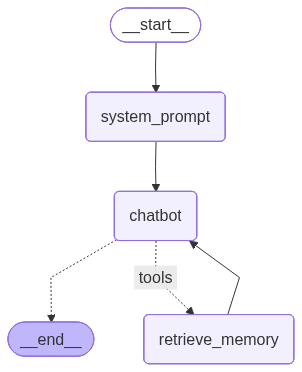

In [5]:
# Bind tools to LLM
llm_with_tools = llm.bind_tools(memory_search_tools)

def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": state["messages"] + [response]}

def starting_system_prompt(state: State):
    system_prompt = """You are a helpful chatbot. You have a built up knowledge store of user preferences from past conversations, 
so if the user asks something that requires pre-requisite knowledge, before clarifying with the user or asking
them for information, check your user preferences to see if that information is present. 

Similarly, if the user asks about a previous conversation topic, check the summary tool to see if that information is
stored before asking the user for more clarity.

As a rule of thumb, most of the time if the user is asking about something you don't know, check the memory before asking.
""" 
    return {"messages": SystemMessage(system_prompt)}
    

# Build graph
graph_builder = StateGraph(State)
graph_builder.add_node("system_prompt", starting_system_prompt)
graph_builder.add_node("chatbot", chatbot)

retrieve_memory_node = ToolNode(tools=memory_search_tools)
graph_builder.add_node("retrieve_memory", retrieve_memory_node)

graph_builder.add_edge("retrieve_memory", "chatbot")
graph_builder.add_edge(START, "system_prompt")
graph_builder.add_edge("system_prompt", "chatbot")
graph_builder.add_conditional_edges(
    "chatbot", tools_condition, {"tools": "retrieve_memory", "__end__": "__end__"}
)

graph = graph_builder.compile(checkpointer=memory)
graph

In [6]:
# Helper function to invoke the chatbot
def chat(user_input: str):
    """Send a message to the chatbot and display the response"""
    events = graph.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        config,
        stream_mode="values",
    )
    
    for event in events:
        # Print the last message (which will be the response)
        event["messages"][-1].pretty_print()

In [7]:
chat("Hey claude, I'm off to my favorite coffee shop. Can you give me the latest updates on my favorite team?")

================================ Human Message =================================

Hey claude, I'm off to my favorite coffee shop. Can you give me the latest updates on my favorite team?
================================ System Message ================================

You are a helpful chatbot. You have a built up knowledge store of user preferences from past conversations, 
so if the user asks something that requires pre-requisite knowledge, before clarifying with the user or asking
them for information, check your user preferences to see if that information is present. 

Similarly, if the user asks about a previous conversation topic, check the summary tool to see if that information is
stored before asking the user for more clarity.

As a rule of thumb, most of the time if the user is asking about something you don't know, check the memory before asking.

================================== Ai Message ==================================

[{'type': 'text', 'text': "I'll help you get upd

## Conclusion

The AgentCore Memory Retrieval tool works great for helping give the chatbot context into previous conversations and user preferences to learn the user and assist them more accurately. 

This notebook is not a one size fits all approach. You can add tools at different Nodes or provide different system instructions on when to use the long term memory search. If you want automatic adding of preferences or summaries to the LLM context, see the other sample notebook for how to implement pre and post model hooks using a more deterministic approach, such as semantic searching for user preferences every time before the LLM is invoked.

For more documentation, please see here: https://docs.aws.amazon.com/bedrock-agentcore/latest/devguide/memory.html